In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
Base = automap_base()

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# We can view all of the classes that automap found

row_list = session.query(Station)

for row in row_list:
    print(row)
    break

TypeError: 'station' object does not support indexing

In [ ]:
# Save references to each table


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine.connect)
conn = engine.connect()

# Exploratory Climate Analysis

In [35]:

from datetime import datetime

now = datetime.now() # current date and time

year = now.strftime("%Y")
print("year:", year)

month = now.strftime("%m")
print("month:", month)

day = now.strftime("%d")
print("day:", day)

time = now.strftime("%H:%M:%S")
print("time:", time)

date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("date and time:",date_time)



year: 2020
month: 08
day: 02
time: 16:42:07
date and time: 08/02/2020, 16:42:07


AttributeError: 'str' object has no attribute 'strftime'

In [45]:
datetimeObj = datetime.strptime(last_date[0], '%Y-%m-%d')
dateObj = datetimeObj.date()
print(dateObj)
print(type(dateObj))
year = dateObj.strftime("%Y")
print("year:", year)
print(type(year))


2017-08-23
<class 'datetime.date'>
year: 2017
<class 'str'>


In [105]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
data = pd.read_sql("SELECT max(date) as final_date FROM measurement ", conn)
last_date = data.iloc[0].tolist()
datetimeObj = datetime.strptime(last_date[0], '%Y-%m-%d')
year = datetimeObj.strftime("%Y")
year = int(year) -1
new_year = str(year) + '-' + datetimeObj.strftime("%m") + '-' + datetimeObj.strftime("%d")
print(new_year)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement where date > '{new_year}'"
print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column

data = pd.read_sql(f"SELECT date, prcp FROM measurement where date > '{new_year}'", conn)

data.set_index('date',inplace=True)

# Sort the dataframe by date

data.sort_index(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
data.dropna(inplace=True)


2016-08-23
SELECT date, prcp FROM measurement where date > '2016-08-23'


In [106]:
data.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


In [107]:

plt.xticks(range(len(data)), data['date'])
plt.bar(range(len(data)),data['prcp'])
plt.xlabel('Date')
plt.ylabel('Inches of Rain')

plt.show

KeyError: 'date'

In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [73]:
# Design a query to show how many stations are available in this dataset?
station_count = pd.read_sql("SELECT count(station) from station", conn)
station_count.head()

,count(station)
0,9


In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active = pd.read_sql("SELECT station, count(station) as Station_count from measurement group by station order by Station_count desc", conn)
active.head(10)


,station,Station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = pd.read_sql("SELECT station, min(tobs) as 'Lowest temperature', max(tobs) as 'Maximum temperature', AVG(tobs) as 'Average Temperature', count(tobs) as Number_of_readings from measurement group by station order by Number_of_readings desc", conn)
temps.head(10)


,station,Lowest temperature,Maximum temperature,Average Temperature,Number_of_readings
0,USC00519281,54.0,85.0,71.663781,2772
1,USC00519397,56.0,87.0,74.553231,2724
2,USC00513117,59.0,85.0,72.689184,2709
3,USC00519523,56.0,85.0,74.543649,2669
4,USC00516128,58.0,84.0,70.915008,2612
5,USC00514830,58.0,85.0,74.873297,2202
6,USC00511918,53.0,87.0,71.615968,1979
7,USC00517948,58.0,87.0,74.684402,1372
8,USC00518838,58.0,83.0,72.724070,511


In [91]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
print(new_year)
query = f"SELECT date, tobs FROM measurement where station = 'USC00519281' and date > '{new_year}'"
print(query)
data = pd.read_sql(f"SELECT date, tobs FROM measurement where date > '{new_year}'", conn)


2016-08-23
SELECT date, tobs FROM measurement where station = 'USC00519281' and date > '2016-08-23'


In [92]:
data.head()


,date,tobs
0,2016-08-24,79.0
1,2016-08-25,80.0
2,2016-08-26,79.0
3,2016-08-27,77.0
4,2016-08-28,78.0


(array([  4.,   6.,  17.,  15.,  51.,  31., 110.,  92., 231., 125., 117.,
        344., 209., 409., 158., 241.,  42.,  18.,   1.,   2.]),
 array([58.  , 59.45, 60.9 , 62.35, 63.8 , 65.25, 66.7 , 68.15, 69.6 ,
        71.05, 72.5 , 73.95, 75.4 , 76.85, 78.3 , 79.75, 81.2 , 82.65,
        84.1 , 85.55, 87.  ]),
 <BarContainer object of 20 artists>)

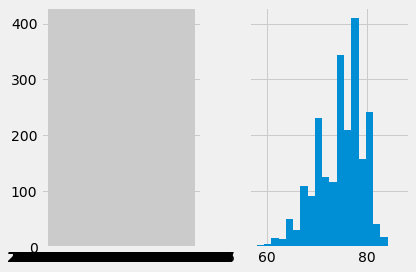

In [93]:

n_bins = 20

x = data['date']
y = data['tobs']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
